In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.optimizers import Adam

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
url = 'https://raw.githubusercontent.com/isu92neth/Weather-RNN/main/weatherHistory.csv'
df = pd.read_csv(url)

titles = ['Date','Summary','Precip Type','Temperature',
 'Apparent Temperature','Humidity','Wind Speed',
 'Wind Bearing','Visibility','Loud Cover',
 'Pressure','Daily Summary']


df.columns = titles

# index form
df['Date'] = pd.to_datetime(df['Date'], utc=True)

date_time = df['Date']

df = df.set_index('Date')

# sort 
df= df.sort_index()

del df['Summary']
del df['Precip Type']
del df['Daily Summary']
del df['Loud Cover']



df

,Temperature,Apparent Temperature,Humidity,Wind Speed,Wind Bearing,Visibility,Pressure
Date,,,,,,,
2005-12-31 23:00:00+00:00,0.577778,-4.050000,0.89,17.1143,140.0,9.9820,1016.66
2006-01-01 00:00:00+00:00,1.161111,-3.238889,0.85,16.6152,139.0,9.9015,1016.15
2006-01-01 01:00:00+00:00,1.666667,-3.155556,0.82,20.2538,140.0,9.9015,1015.87
2006-01-01 02:00:00+00:00,1.711111,-2.194444,0.82,14.4900,140.0,9.9015,1015.56
2006-01-01 03:00:00+00:00,1.183333,-2.744444,0.86,13.9426,134.0,9.9015,1014.98
...,...,...,...,...,...,...,...
2016-12-31 18:00:00+00:00,0.488889,-2.644444,0.86,9.7566,167.0,8.0178,1020.03
2016-12-31 19:00:00+00:00,0.072222,-3.050000,0.88,9.4185,169.0,7.2450,1020.27
2016-12-31 20:00:00+00:00,-0.233333,-3.377778,0.89,9.2736,175.0,9.5795,1020.50


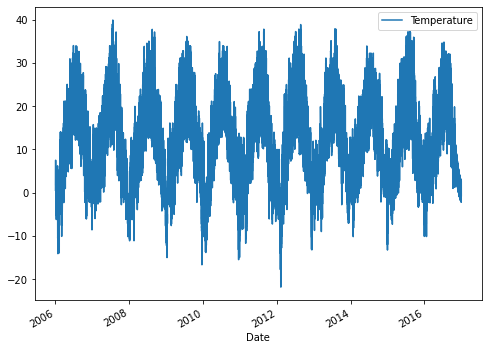

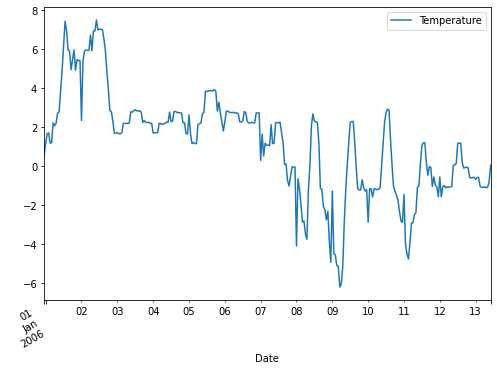

In [ ]:
#plot_cols = ['Temperature','Humidity','Wind Speed','Wind Bearing','Pressure','Visibility']
plot_cols = ['Temperature']
plot_features = df[plot_cols]

_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:300]

_ = plot_features.plot(subplots=True)

Patterns I see:
- Temperature has a yearly pattern
- Temperature has an daily pattern as well.

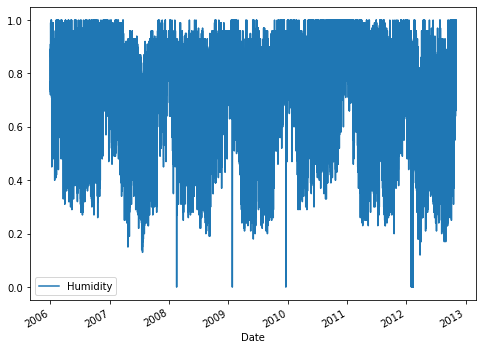

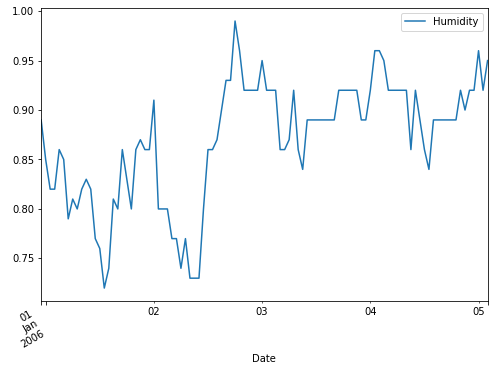

In [ ]:
plot_cols = ['Humidity']

plot_features = df[plot_cols][:60000]

_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:100]

_ = plot_features.plot(subplots=True)

Patterns I see:

- Humidity has a yearly pattern
-  Humidity has an daily pattern as well



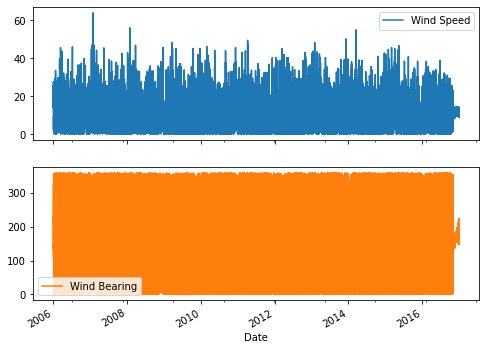

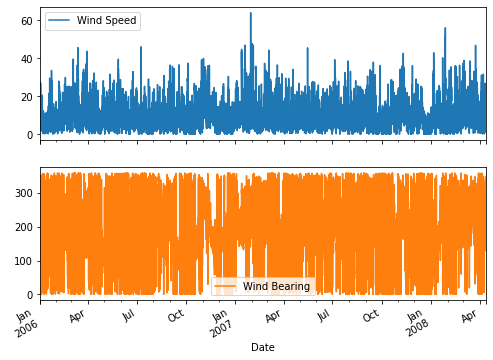

In [ ]:
plot_cols = ['Wind Speed', 'Wind Bearing']
plot_features = df[plot_cols]

_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:20000]

_ = plot_features.plot(subplots=True)

(1000.0, 1100.0)

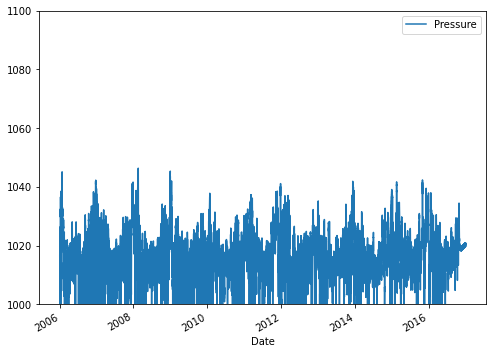

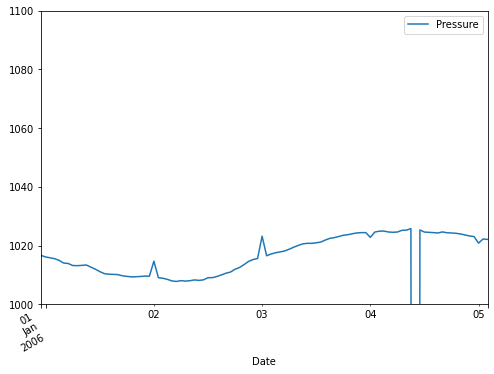

In [ ]:
plot_cols = ['Pressure']
plot_features = df[plot_cols]

_ = plot_features.plot(subplots=True)
plt.ylim([1000, 1100])

plot_features = df[plot_cols][:100]
_ = plot_features.plot(subplots=True)
plt.ylim([1000, 1100])

Patterns I see,
- Pressure has a yearly pattern

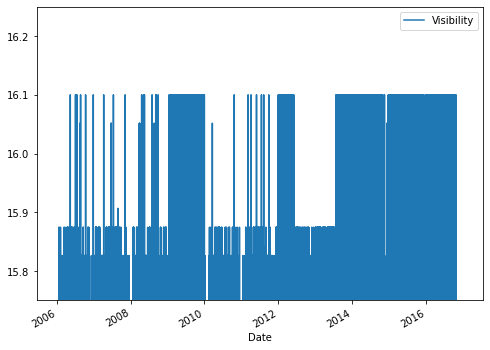

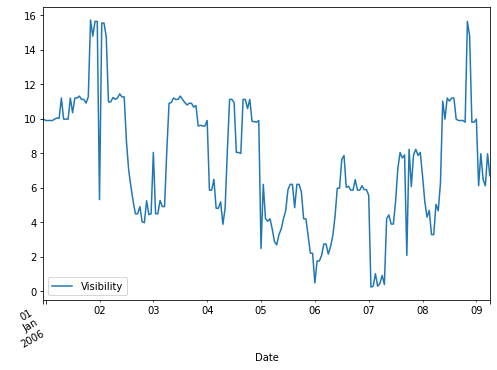

In [ ]:
plot_cols = ['Visibility']
plot_features = df[plot_cols]

_ = plot_features.plot(subplots=True)
plt.ylim([15.75, 16.25])


plot_features = df[plot_cols][:200]
_ = plot_features.plot(subplots=True)

Patterns I see
- Visibility has a rougly daily pattern

# Feature Engineering

## Wind Speed and Wind Bearing

Text(0, 0.5, 'Wind Velocity [m/s]')

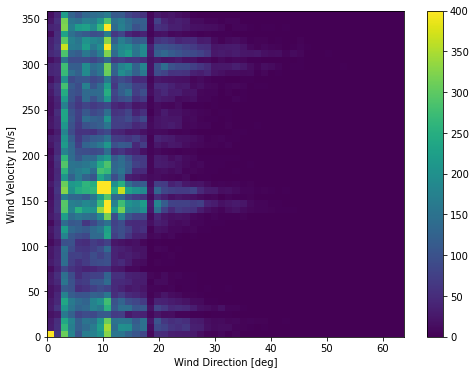

In [ ]:
plt.hist2d(df['Wind Speed'], df['Wind Bearing'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Text(0, 0.5, 'Wind Y [m/s]')

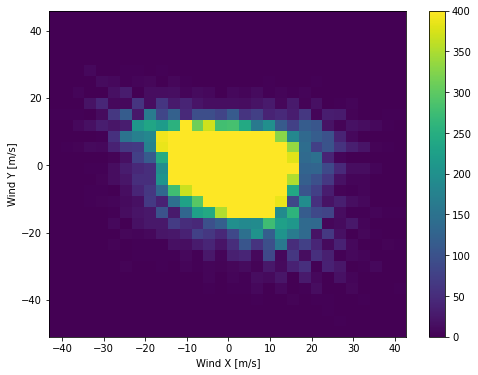

In [ ]:
wv = df['Wind Speed']
wv_max = wv.max()

wd_rad = (df['Wind Bearing'])*np.pi / 180

wdx = np.array([])
wdy = np.array([])
wdx = wv*np.cos(wd_rad)
wdy = wv*np.sin(wd_rad)

df['Wind X'] = wdx
df['Wind Y'] = wdy


plt.hist2d(wdx, wdy, bins=(30, 30), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')


## Time

Text(0.5, 1.0, 'Time of day signal')

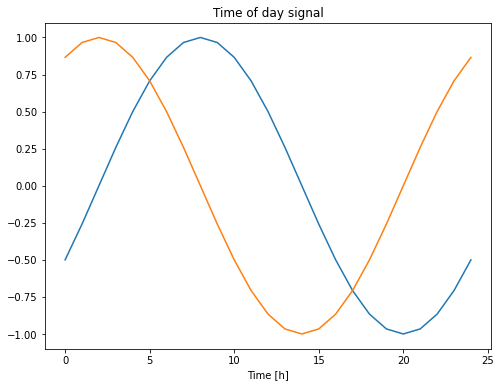

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)


day = 24*60*60
year = (365.2425)*day

day_sin = np.sin(timestamp_s * (2 * np.pi / day))
day_cos = np.cos(timestamp_s * (2 * np.pi / day))
year_sin = np.sin(timestamp_s * (2 * np.pi / year))
year_cos = np.cos(timestamp_s * (2 * np.pi / year))


plt.plot(np.array(day_sin)[:25])
plt.plot(np.array(day_cos)[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')





Text(0.5, 1.0, 'Time of year signal')

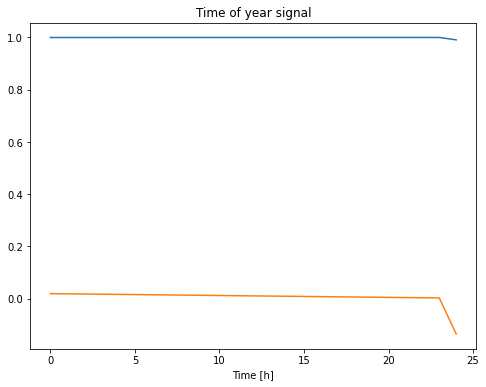

In [ ]:
plt.plot(np.array(year_sin)[:25])
plt.plot(np.array(year_cos)[:25])
plt.xlabel('Time [h]')
plt.title('Time of year signal')

Text(0.5, 1.0, 'Temperature')

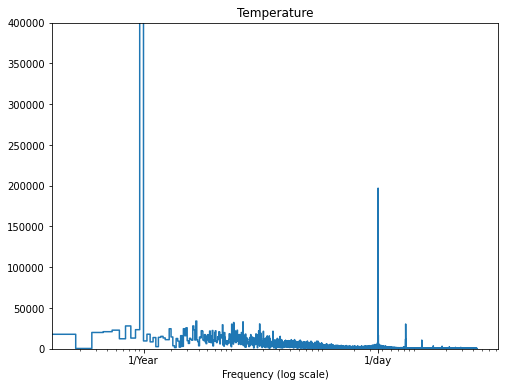

In [ ]:
fft = tf.signal.rfft(df['Temperature'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Temperature'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.title('Temperature')

Text(0.5, 1.0, 'Humidity')

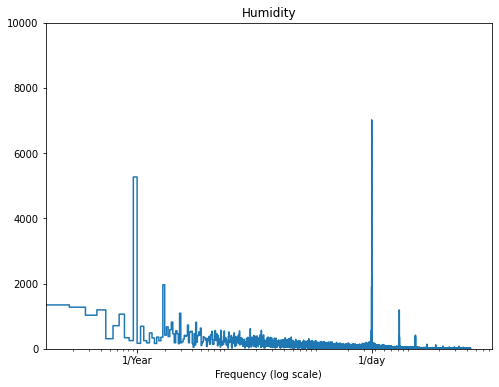

In [ ]:
fft = tf.signal.rfft(df['Humidity'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Humidity'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 10000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.title('Humidity')

Text(0.5, 1.0, 'Wind X')

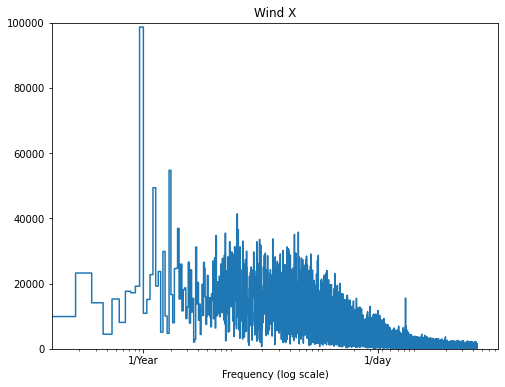

In [ ]:
fft = tf.signal.rfft(wdx)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(wdx)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.title('Wind X')

Text(0.5, 1.0, 'Wind Y')

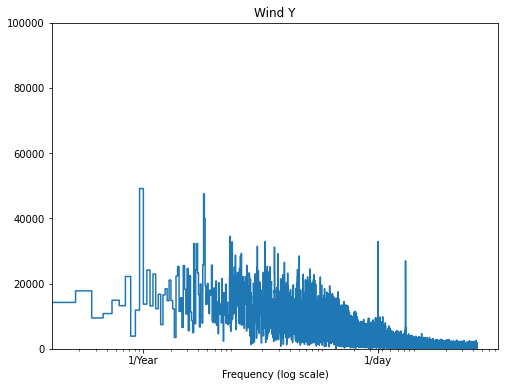

In [ ]:
fft = tf.signal.rfft(wdy)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(wdy)
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.title('Wind Y')



Text(0.5, 1.0, 'Pressure')

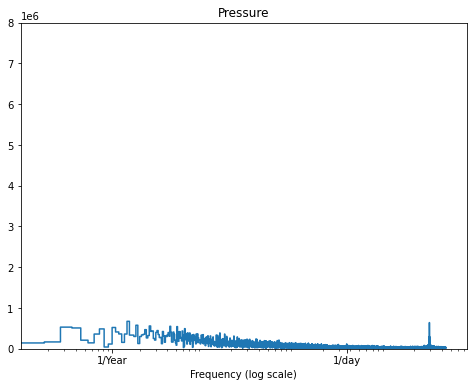

In [ ]:
fft = tf.signal.rfft(df['Pressure'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Pressure'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 8000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.title('Pressure')

Text(0.5, 1.0, 'Visibility')

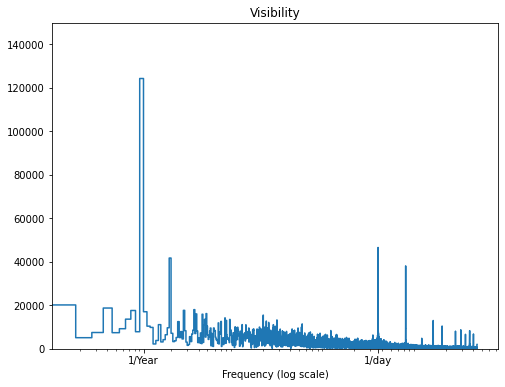

In [ ]:
fft = tf.signal.rfft(df['Visibility'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Visibility'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 150000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')
plt.title('Visibility')

# Splitting Data

You'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons:

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

column_indices

{'Apparent Temperature': 1,
 'Humidity': 2,
 'Pressure': 6,
 'Temperature': 0,
 'Visibility': 5,
 'Wind Bearing': 4,
 'Wind Speed': 3,
 'Wind X': 7,
 'Wind Y': 8}

# Normalizing

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

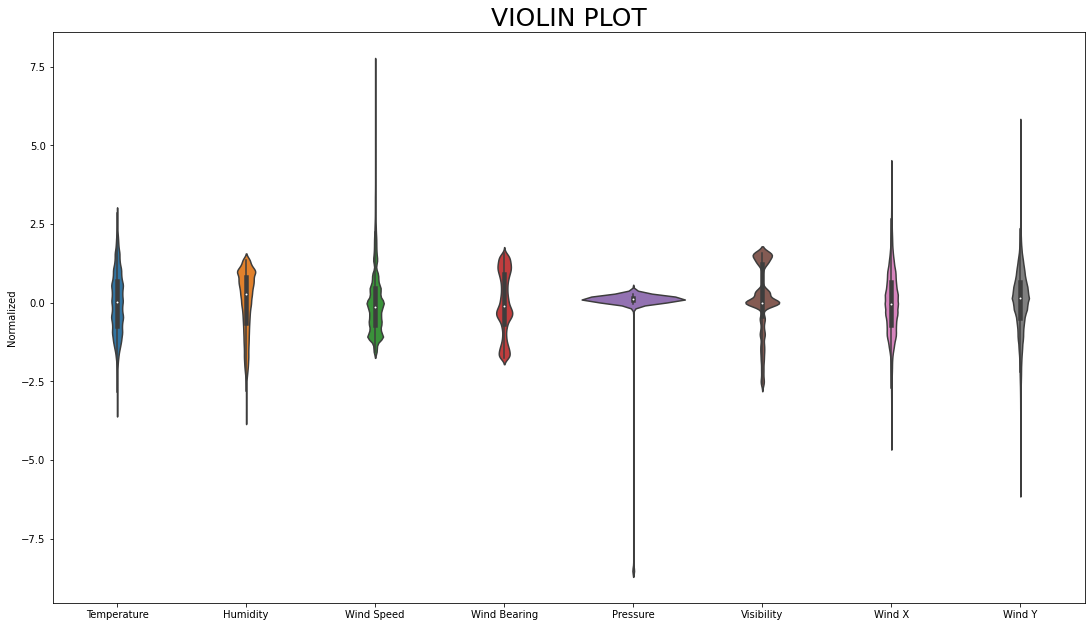

In [ ]:
numerical_types = ['Temperature','Humidity','Wind Speed','Wind Bearing','Pressure','Visibility','Wind X','Wind Y']

def Violin(data):
  plt.figure(figsize=(10,4))
  plt.title('VIOLIN PLOT', fontsize=25)
  sns.violinplot(data=data[numerical_types])
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  plt.ylabel('Normalized')
  plt.show()

df_std = (df - train_mean) / train_std
Violin(df_std)


# Data Windowing

## 1. Indexes and offsets

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['Temperature'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Temperature'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [ ]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


## 3. plot

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Temperature', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


# RNN - Autoregressive

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  
  

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(clipvalue=0.5),
                metrics=[tf.metrics.MeanAbsoluteError()])
  

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUT_STEPS = 24*5
multi_window = WindowGenerator(input_width=24*30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])


In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 9])

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

577/577 [==============================] - 41s 72ms/step - loss: 0.8054 - mean_absolute_error: 0.6053


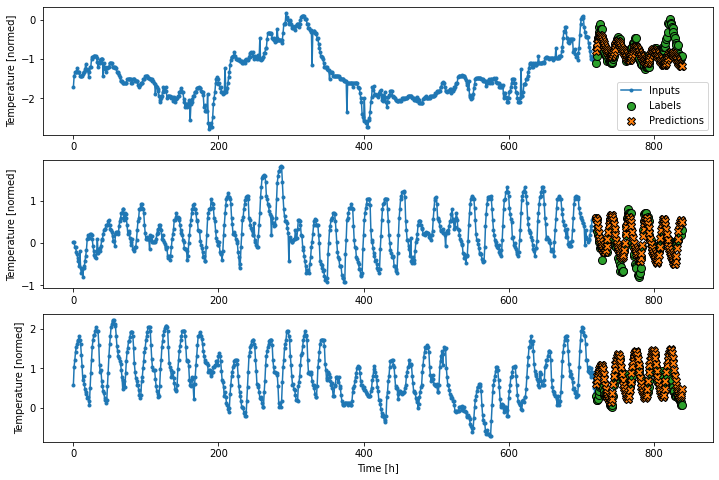

In [ ]:
multi_val_performance = {}
multi_performance = {}

history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

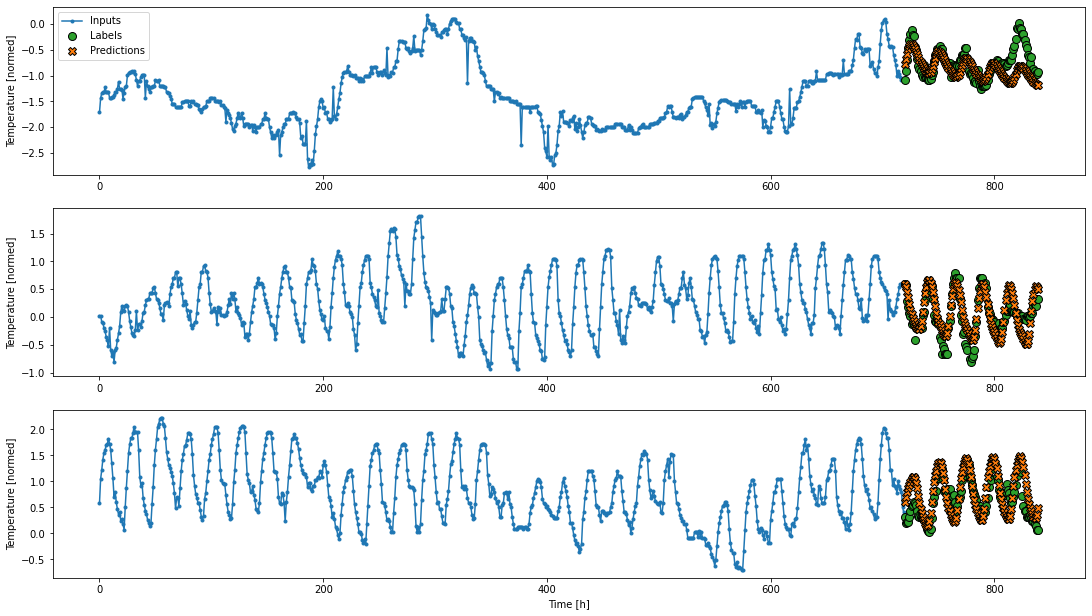

In [ ]:
multi_window.plot(feedback_model)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
